## Deep Learning for Time Series 

Deep Learning is a subset of machine learning and excels when dealing with large and complex data, as it can extract complex features with minimal human involvement. Deep learning works well with structured and unstructured data and can be used in supervised, unsupervised and semi-supervised learning. 

This chapter focuses on using deep learning for time series forecasting - using different deep learning architectures suitable for sequential data such as time series data. There are different deep learning architectures for solving various problems: 

* Recurrent Neural Networks (RNNs)
* Long-Short Term Memory (LSTM)
* Gated Recurrent Unit (GRU)
* Convolutional Neural Networks (CNNs)
* Autoencoders
* Generative Adversarial Networks (GANs)

In [7]:
import pandas as pd 
import numpy as np 


In [8]:
class Standardize:
    def __init__(self, df, split=0.10):
        self.data = df 
        self.split = split 

    def split_data(self):
        n = int(len(self.data) * self.split)
        train, test = self.data.iloc[:-n], self.data.iloc[-n:]
        n = int(len(train) * self.split)
        train, val = train.iloc[:-n], train.iloc[-n:]
        assert len(test) + len(train) + len(val) == len(self.data)
        return train, test, val 
    
    def _transform(self, data):
        data_s = (data - self.mu)/self.sigma 
        return data_s 
    
    def fit_transform(self):
        train, test, val = self.split_data()
        self.mu, self.sigma = train.mean(), train.std()
        train_s = self._transform(train)
        test_s = self._transform(test)
        val_s = self._transform(val)
        return train_s, test_s, val_s 
    
    def inverse(self, data):
        return (data * self.sigma)+self.mu 
    
    def inverse_y(self, data):
        return (data * self.sigma[-1])+self.mu[-1]
    


In [9]:
def one_step_forecast(df, window):
    d = df.values 
    x = []
    n = len(df)
    idx = df.index[:-window]
    for start in range(n-window):
        end = start + window
        x.append(d[start:end])
    cols = [f'x_{i}' for i in range(1, window+1)]
    x = np.array(x).reshape(n-window, -1)
    y = df.iloc[window:].values
    df_xs = pd.DataFrame(x, columns=cols, index=idx)
    df_y = pd.DataFrame(y.reshape(-1), columns=['y'], index=idx)

    return pd.concat([df_y, df_xs], axis=1).dropna()

In [10]:
# Example 

import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
from pathlib import Path 
import warnings
warnings.filterwarnings('ignore')
path = Path('../TimeSeriesAnalysisWithPythonCookbook/Data/')
energy = pd.read_csv(path.joinpath('energy_consumption.csv'), index_col='Month', parse_dates=True)
energy.columns = ['y']
energy.index.freq = 'MS'
en_df = one_step_forecast(energy, 10)

In [11]:
# Scale the data using the updated Standardize class 
scale_en = Standardize(en_df)

In [12]:
train_en, test_en, val_en = scale_en.fit_transform()

Deep Learning libraries can be broken down into either **low-level, high-level** or both. High-level libraries allow for quick prototyping and experimentation when testing various architectures, such as the case with Keras. A low-level library gives us more flexibility and control, but we will have to define more aspects of a model's architecture - PyTorch and Tensorflow are examples of low-level libraries. 

## Forecasting with an RNN using Keras 

RNNs initially entered the spotlight with NLP, as they were designed for sequential data, where past observations, such as words, have a strong influence on determining the next word in a sentence. This need for the artificial neural network to retain memory (hidden state) inspired the RNN architecture. Similarly, time series data is also sequential, and since past observations influece future observations, it also needs a network with memory. 

In RNNs, there is a feedback loop where the output of one node or neuron is fed back (the recursive part) as input, allowing the network to learn from a prior time step acting as a memory. 

In an RNN we have two outputs and two sets of weights: $W_{X}$ for the input and $W_{H}$ for the hidden state or memory



In [30]:
from tensorflow.keras import Sequential
from tensorflow import keras 
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from keras.layers import Dense, SimpleRNN, Dropout, LSTM, GRU, Bidirectional, TimeDistributed, BatchNormalization 



In [15]:
# Create the features_target_ts function that takes a dataset and returns an x split 
# (independent variables or features) and y split (dependent or target variables)

def features_target_ts(*args):
    y = [col.pop('y').values.reshape(-1,1) for col in args]
    x = [col.values.reshape(*col.shape, 1) for col in args]

    return *y, *x


In [16]:
# We can pass the train, test and validation sets to the features_target_ts function and
# it will return six splits

(y_train_en, y_val_en, y_test_en, x_train_en, x_val_en, x_test_en) = features_target_ts(train_en, val_en, test_en)


In [21]:
# Create the create_model function, which is used to construct the network's architecture.
# The Sequential class will sequentially add or stack the different layers in the order added,
# hence the name. We will implement the SimpleRNN architecture 

def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(SimpleRNN(units=units, 
                        return_sequences=False,
                        input_shape=(train.shape[1], 
                                     train.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    return model 


The create_model function will return a Sequential object which contains the architecture (the layers and the configuration). We are adding a dropout layer that randomly drops some of the unity by setting them to zero. The frequency is set at 0.2 (20%), indicating the fraction of the input units to drop. return_sequence is set to False, indicating that only the last output is returned

Create the train_model_ts function, which takes as input the returned Sequential object (which we are calling model), and the training and validation sets. The function will compile and train the model on the training sets and use the validation sets for evaluation at each epoch, displaying the scores against the training and validation sets:

In [22]:
def train_model_ts(model, x_train, y_train, x_val, y_val, epochs=500, patience=12, batch_size=32):
    model.compile(optimizer="adam", 
                  loss='mean_squared_error', 
                  metrics=[RootMeanSquaredError(), 
                           MeanAbsoluteError()])
    
    es = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", 
        min_delta=0, 
        patience=patience)
    
    history = model.fit(x_train, y_train, 
                        shuffle=False, epochs=epochs, 
                        batch_size=batch_size, 
                        validation_data = (x_val, y_val), 
                        callbacks=[es], verbose=1)
    
    return history


The function will return the history object, which is a Python dictionary that includes all the scores captured at each epoch for the training and validation sets



Create the plot_forecast function, which will take the model object to make a prediction (forecast) and print out the predicted values against the actual values (out-of-sample) in the test set. Additionally, the function takes the history dictionary to plot the model's performance during training, so we can visually evaluate the model for any signs of overfitting

In [23]:
def plot_forecast(model, x_test, y_test, index, history):
    fig, ax = plt.subplots(2, 1)
    (pd.Series(history.history['loss']).plot(style='k', alpha=0.5, title='Loss by Epoch',
           ax = ax[0], label='loss'))
    
    (pd.Series(history.history['val_loss']).plot(style='k', ax=ax[0], label='val_loss'))
    ax[0].legend()
    predicted = model.predict(x_test)
    pd.Series(y_test.reshape(-1), 
              index=index).plot(style='k--', alpha=0.5, ax=ax[1], title="Forecast vs Actual", label='actual')
    pd.Series(predicted.reshape(-1), 
              index=index).plot(style='k', label='Forecast', ax=ax[1])
    fig.tight_layout()
    ax[1].legend()
    plt.show()
    

The function displays two subplots - the first plot will contain the performance during training (training and validation loss) and the bottom chart will compare the forecast. 


In [24]:
# Use the create_model function to create the Sequential object

model_en_simpleRNN = create_model(x_train_en, units=32)

In [25]:
model_en_simpleRNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1088      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


In [26]:
# Train the model using the train_model function
history_en_simpleRNN = train_model_ts(model_en_simpleRNN, x_train_en, y_train_en, x_val_en, y_val_en, batch_size=64)

Epoch 1/500
8/8 [==============================] - 1s 37ms/step - loss: 0.8709 - root_mean_squared_error: 0.9332 - mean_absolute_error: 0.7776 - val_loss: 0.9693 - val_root_mean_squared_error: 0.9845 - val_mean_absolute_error: 0.8419
Epoch 2/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5244 - root_mean_squared_error: 0.7242 - mean_absolute_error: 0.5881 - val_loss: 0.6268 - val_root_mean_squared_error: 0.7917 - val_mean_absolute_error: 0.6771
Epoch 3/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4263 - root_mean_squared_error: 0.6529 - mean_absolute_error: 0.5337 - val_loss: 0.4077 - val_root_mean_squared_error: 0.6385 - val_mean_absolute_error: 0.5279
Epoch 4/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2795 - root_mean_squared_error: 0.5286 - mean_absolute_error: 0.4107 - val_loss: 0.3002 - val_root_mean_squared_error: 0.5479 - val_mean_absolute_error: 0.4349
Epoch 5/500
8/8 [==============================] - 0s 8ms/step - lo

2/2 [==============================] - 0s 3ms/step


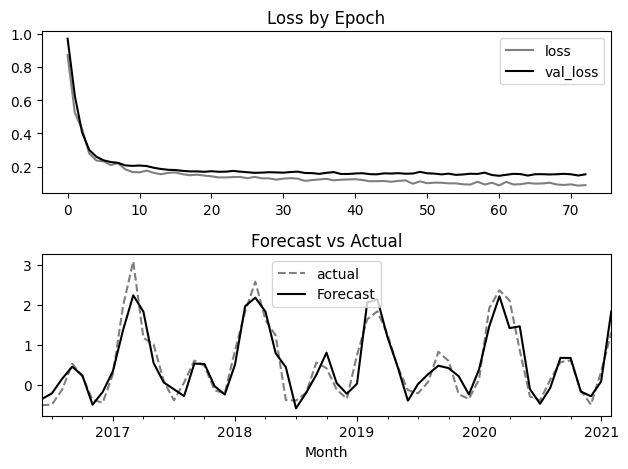

In [27]:
# Evaluate the model using the plot_forecast function

plot_forecast(model_en_simpleRNN, x_test_en, y_test_en, test_en.index, history_en_simpleRNN)

The top plot "loss by epoch" helps us evaluate the overall training progress. the goal is to minimize the loss function, and both curves (training loss and validation loss) are going down smoothly and not departing from each other, which can be a sign of overfitting. 



In [28]:
# Create the same RNN architecture but this time using the functional API

from tensorflow.keras import Model 
from keras.layers import (Dense, SimpleRNN, Dropout, Input)


In [29]:
# Create a new create_model function 

def create_model(train, units, dropout=0.2):
    input_data = Input(shape=(10,1))
    rnn = SimpleRNN(units, return_sequences=True)(input_data)
    dropout = Dropout(dropout)(rnn)
    output = Dense(1)(dropout)
    model = Model(inputs=input_data, outputs=output)
    return model 


## Forecasting with LSTM using Keras 

There are shortcomings using RNNs - for example, an RNN's memory is short term and does not do well when persisting a longer-term memory.

In a deep RNN with multiple hidden layers, the network will suffer from the **vanishing gradient** problem - that is, during backpropagation, as the weights get adjusted, it will be unable to change the weights of much earlier layers, reducing its ability to learn. Because of this, the output becomes influenced by the closer layers (nodes)

In other words, any memory of earlier layers decays through time, hence the term **vanishing**. This is an issue if we have a very long sequence. In time series data, how problematic the lack of long-term memory is will vary, depending on our goal and the data we are working with. More specifically, our domain knowledge about the time series process comes into play. If long-term memory is needed, then LSTM offers a more robust solution to RNNs. Another alternative is the GRU.



In [35]:
# Create another create_model with LSTM layers

def create_model_LSTM(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(LSTM(units=units,
                   input_shape=(train.shape[1], 
                                train.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    return model 
    

In [36]:
# Use the create_model function to create a sequential object
model_en_lstm = create_model_LSTM(train=x_train_en, units=32)
model_en_lstm.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 32)                4352      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [37]:
# Use the train_model function to train the model and store the returned dictionay
# as history_en_lstm

history_en_lstm = train_model_ts(model_en_lstm, x_train_en, y_train_en, x_val_en, y_val_en, batch_size=64)


Epoch 1/500
8/8 [==============================] - 2s 60ms/step - loss: 0.8948 - root_mean_squared_error: 0.9460 - mean_absolute_error: 0.7748 - val_loss: 1.2357 - val_root_mean_squared_error: 1.1116 - val_mean_absolute_error: 0.8325
Epoch 2/500
8/8 [==============================] - 0s 10ms/step - loss: 0.8643 - root_mean_squared_error: 0.9297 - mean_absolute_error: 0.7597 - val_loss: 1.2057 - val_root_mean_squared_error: 1.0980 - val_mean_absolute_error: 0.8262
Epoch 3/500
8/8 [==============================] - 0s 9ms/step - loss: 0.8404 - root_mean_squared_error: 0.9167 - mean_absolute_error: 0.7501 - val_loss: 1.1751 - val_root_mean_squared_error: 1.0840 - val_mean_absolute_error: 0.8194
Epoch 4/500
8/8 [==============================] - 0s 9ms/step - loss: 0.8140 - root_mean_squared_error: 0.9022 - mean_absolute_error: 0.7377 - val_loss: 1.1464 - val_root_mean_squared_error: 1.0707 - val_mean_absolute_error: 0.8120
Epoch 5/500
8/8 [==============================] - 0s 9ms/step - l

2/2 [==============================] - 0s 3ms/step


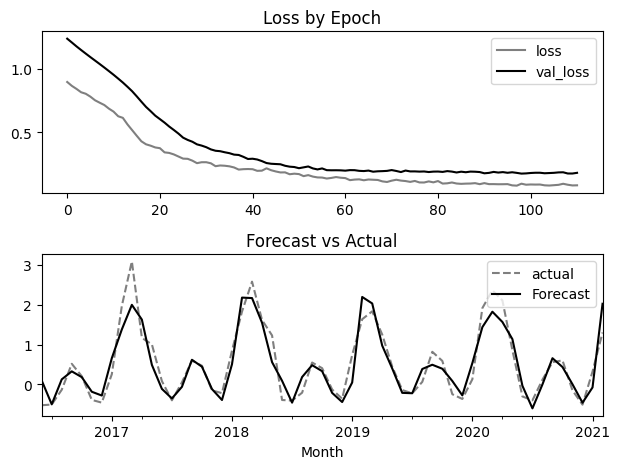

In [38]:
# Use the plot_forecaste to evaluate the LSTM model 

plot_forecast(model_en_lstm, x_test_en, y_test_en, test_en.index, history_en_lstm)


In [41]:
# Using the functional API, we can create a deep LSTM with two hidden layers 

from tensorflow.keras import Model 
from keras.layers import (Dense, SimpleRNN, Dropout, Input)

def create_model(train, units, dropout=0.2):
    input_data = Input(shape=(10,1))
    lstm_1 = LSTM(units, return_sequences=True)(input_data)
    dropout_1 = Dropout(dropout)(lstm_1)
    lstm_2 = LSTM(units)(dropout_1)
    dropout_2 = Dropout(dropout)(lstm_2)
    output = Dense(1)(dropout_2)
    model = Model(inputs=input_data, outputs=output)

    return model 

## Forecasting with a GRU using Keras 

GRU was proposed as an alternative to RNN to combat the vanishing gradient problem by introducing the gates concept. As with an LSTM, the gates are used to regulate what and how the data flows. These gates are mathematical functions that act as filters to ensure only significant piecs of information are being retained. 

In [44]:
# Create another create_model function with GRU layer

def create_model_GRU(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(GRU(units=units, 
                  input_shape=(train.shape[1], 
                                train.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    return model 


In [45]:
# Use the create_model function to create a sequential object

model_en_gru = create_model_GRU(x_train_en, units=32)
model_en_gru.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 32)                3360      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,393
Trainable params: 3,393
Non-trainable params: 0
_________________________________________________________________


In [46]:
# Use the train_model_ts function to train the model and store the returned dict as history_en_gru

history_en_gru = train_model_ts(model_en_gru, x_train_en, y_train_en, x_val_en, y_val_en, batch_size=64)


Epoch 1/500
8/8 [==============================] - 2s 50ms/step - loss: 1.2454 - root_mean_squared_error: 1.1160 - mean_absolute_error: 0.8930 - val_loss: 1.6505 - val_root_mean_squared_error: 1.2847 - val_mean_absolute_error: 0.9095
Epoch 2/500
8/8 [==============================] - 0s 11ms/step - loss: 1.1303 - root_mean_squared_error: 1.0631 - mean_absolute_error: 0.8569 - val_loss: 1.5245 - val_root_mean_squared_error: 1.2347 - val_mean_absolute_error: 0.8819
Epoch 3/500
8/8 [==============================] - 0s 8ms/step - loss: 1.0450 - root_mean_squared_error: 1.0222 - mean_absolute_error: 0.8261 - val_loss: 1.4160 - val_root_mean_squared_error: 1.1900 - val_mean_absolute_error: 0.8648
Epoch 4/500
8/8 [==============================] - 0s 9ms/step - loss: 0.9744 - root_mean_squared_error: 0.9871 - mean_absolute_error: 0.8059 - val_loss: 1.3274 - val_root_mean_squared_error: 1.1521 - val_mean_absolute_error: 0.8506
Epoch 5/500
8/8 [==============================] - 0s 8ms/step - l

2/2 [==============================] - 0s 3ms/step


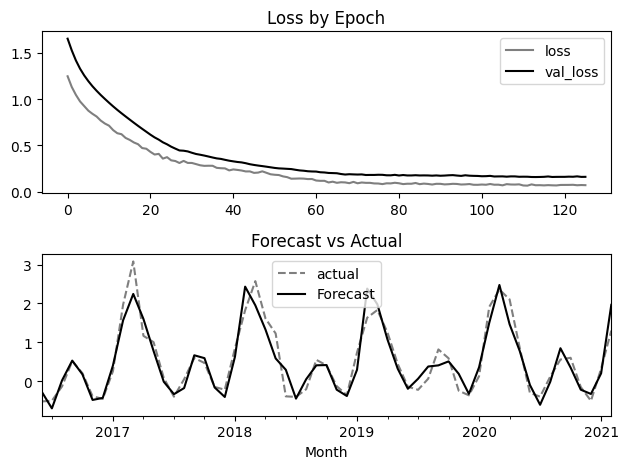

In [47]:
# Use the plot_forecast to evaluate the GRU model

plot_forecast(model_en_gru, x_test_en, y_test_en, test_en.index, history_en_gru)

## Forecasting with an RNN using PyTorch 

...